# Problem Statement

You have now learned to decompose a time series into **seasonal** and **trend** components and to use time series to forecast into the future using `statsmodels`. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

1. **Data description**: Provide a high-level overview of your data and its timeframe along with general information on your dataset
2. **Forecast**: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
3. **Uncertainty**: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dataset

Air Quality data for a certain town in India, data collected by local state givernment collution control board

https://www.kaggle.com/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023

In [5]:
df = pd.read_csv('data/AP001.csv.zip', compression = 'zip')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59150 entries, 0 to 59149
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        59150 non-null  object 
 1   To Date          59150 non-null  object 
 2   PM2.5 (ug/m3)    54323 non-null  float64
 3   PM10 (ug/m3)     54450 non-null  float64
 4   NO (ug/m3)       55153 non-null  float64
 5   NO2 (ug/m3)      55100 non-null  float64
 6   NOx (ppb)        55315 non-null  float64
 7   NH3 (ug/m3)      53564 non-null  float64
 8   SO2 (ug/m3)      54285 non-null  float64
 9   CO (mg/m3)       54673 non-null  float64
 10  Ozone (ug/m3)    54567 non-null  float64
 11  Benzene (ug/m3)  55213 non-null  float64
 12  Toluene (ug/m3)  55213 non-null  float64
 13  Temp (degree C)  55113 non-null  float64
 14  RH (%)           55281 non-null  float64
 15  WS (m/s)         55299 non-null  float64
 16  WD (deg)         54656 non-null  float64
 17  SR (W/mt2)  

In [7]:
df.describe()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
count,54323.000000,54450.000000,55153.000000,55100.000000,55315.000000,53564.000000,54285.000000,54673.000000,54567.000000,55213.000000,...,55113.000000,55281.000000,55299.000000,54656.000000,54589.000000,1201.000000,55341.000000,55200.000000,55285.000000,55087.000000
mean,29.718423,58.531252,13.077963,39.195409,31.171453,10.057892,5.782241,0.634884,28.681448,0.813874,...,30.296565,71.962430,1.170445,180.160190,72.830661,755.713988,-0.015668,0.316406,0.052524,22.279584
std,21.365617,32.388101,16.124784,30.716953,25.048555,5.949501,4.538823,0.850052,19.189147,1.398240,...,2.885504,13.575538,0.719358,74.972401,131.376023,14.906888,0.165063,1.594764,0.441987,3.006088
min,0.250000,1.000000,0.100000,0.100000,0.000000,0.100000,0.030000,0.000000,0.070000,0.000000,...,7.300000,15.250000,0.080000,1.000000,0.000000,725.000000,-17.600000,0.000000,0.000000,4.680000
25%,13.250000,34.000000,3.800000,17.400000,13.780000,6.200000,3.650000,0.350000,16.370000,0.330000,...,28.770000,62.500000,0.600000,123.750000,3.000000,751.500000,-0.100000,0.030000,0.000000,20.200000
50%,24.000000,53.500000,8.100000,30.650000,24.880000,8.420000,5.150000,0.570000,22.380000,0.600000,...,29.880000,73.750000,1.050000,183.500000,8.000000,755.250000,-0.030000,0.100000,0.000000,22.050000
75%,42.500000,78.500000,16.170000,52.950000,41.150000,12.200000,6.970000,0.790000,36.000000,1.100000,...,31.350000,84.000000,1.600000,235.250000,71.000000,758.000000,0.030000,0.250000,0.000000,24.250000
max,449.500000,929.000000,288.170000,313.650000,364.800000,195.200000,199.770000,41.100000,199.700000,118.520000,...,59.900000,92.330000,34.850000,360.000000,956.000000,1050.000000,1.700000,127.850000,30.000000,35.350000


In [8]:
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
0,2016-07-01 10:00:00,2016-07-01 11:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.60,0.48,...,33.43,71.67,2.30,226.33,123.67,NaN,-0.1,0.1,0.0,23.05
1,2016-07-01 11:00:00,2016-07-01 12:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,...,33.70,70.00,2.50,223.00,186.00,NaN,-0.1,0.1,0.0,NaN
2,2016-07-01 12:00:00,2016-07-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-01 13:00:00,2016-07-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-01 14:00:00,2016-07-01 15:00:00,20.50,50.0,15.40,43.6,32.78,6.35,6.38,0.47,...,33.57,63.50,1.88,223.00,240.50,NaN,-0.1,0.1,0.0,NaN


In [9]:
feature = 'PM2.5 (ug/m3)'
#feature = 'PM10 (ug/m3)'

X = df.assign(date=pd.to_datetime(df['To Date']))[['date', feature]].set_index('date')

In [10]:
X.rename(columns={feature: 'Value'}, inplace=True)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59150 entries, 2016-07-01 11:00:00 to 2023-04-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   54323 non-null  float64
dtypes: float64(1)
memory usage: 924.2 KB


In [12]:
type(X.index) # Check that  datetime conversion and index creation is legit

pandas.core.indexes.datetimes.DatetimeIndex

### Recommendation:
For hourly environmental data, **interpolation** is often the most suitable method, as it takes into account the temporal nature of the data and provides a more accurate estimate of missing values.

In [14]:
X.isnull().sum()

Value    4827
dtype: int64

In [15]:
X.interpolate(method='time', inplace=True)

If the missing data is not extensive, **forward fill** or **backward fill** can also be effective. Always visualize the data before and after imputation to ensure that the method chosen does not introduce bias or distort the data trends.

In [17]:
# Resample the data to daily frequency and sum the values
daily_totals = X.resample('D').sum()
monthly_totals = X.resample('M').sum()

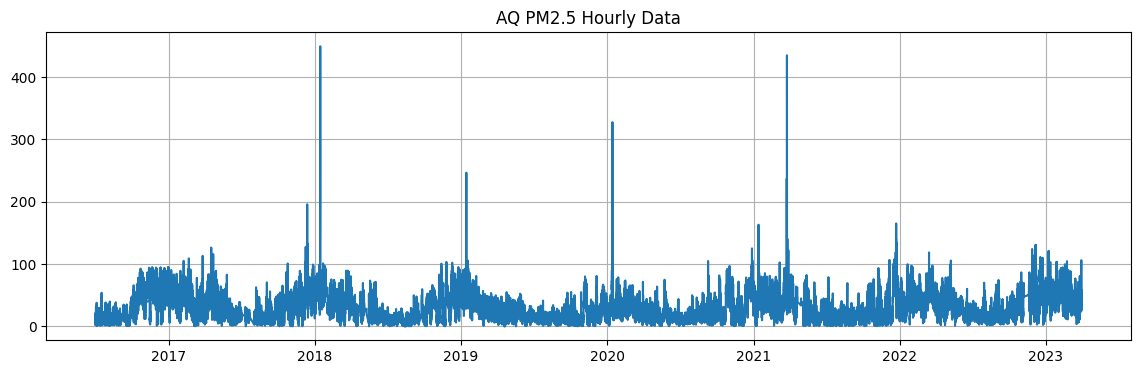

In [18]:
plt.figure(figsize=(14,4))
plt.plot(X)
plt.title('AQ PM2.5 Hourly Data', loc = 'center')
plt.grid();

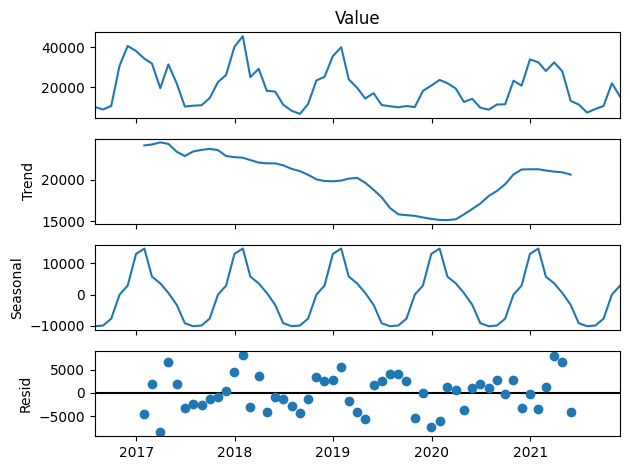

In [19]:
# Step 1: Split the dataset
train_size = int(len(monthly_totals) * 0.8)
train, test = monthly_totals[:train_size], monthly_totals[train_size:]

# Step 2: Decompose the time series
decomposition = seasonal_decompose(train['Value'], model='additive', period = 12)
decomposition.plot()
plt.savefig('images/AQ_decomposition.png')
plt.show()

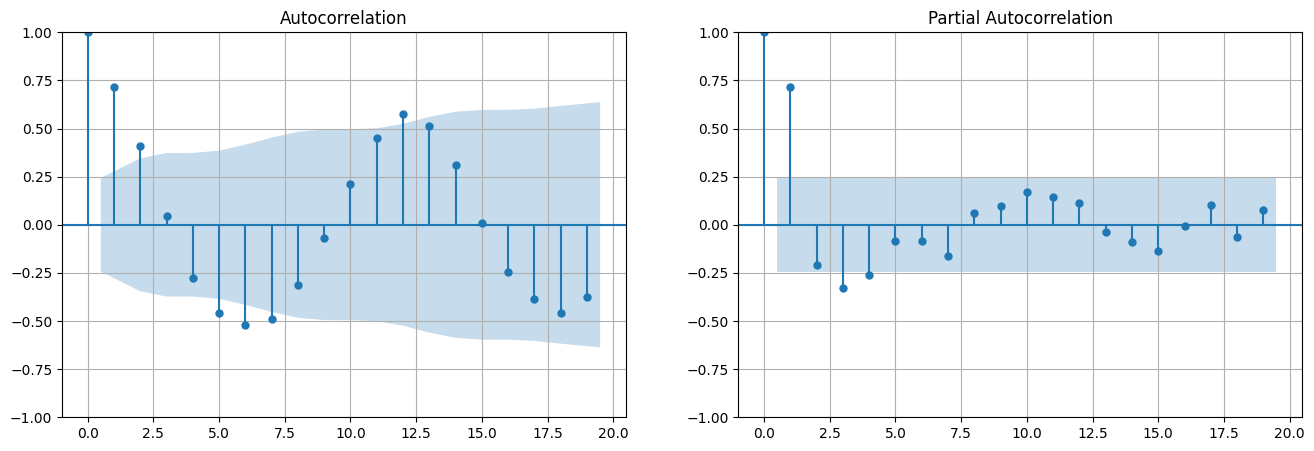

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(train['Value'], ax = ax[0]);
ax[0].grid()
plot_pacf(train['Value'], ax = ax[1], method = 'ywm');
ax[1].grid()
plt.savefig('images/AQ_ACF_and_PACF_plots.png')

## ACF & PACF results

$p = 1, q = 2$

In [22]:
# Step 3: Build the SARIMAX model

p = 1
q = 2
model = SARIMAX(train['Value'], order=(p, 0, q), seasonal_order=(1, 1, 1, 12)) # 12 for monthly seasons
results = model.fit()

# Step 4: Forecast the test set
forecast = results.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
predicted_ci = forecast.conf_int()

# Step 5: Assess accuracy
mae = mean_absolute_error(test['Value'], predicted_mean)
rmse = np.sqrt(mean_squared_error(test['Value'], predicted_mean))

print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 6792.351278191115, RMSE: 9462.901640425083


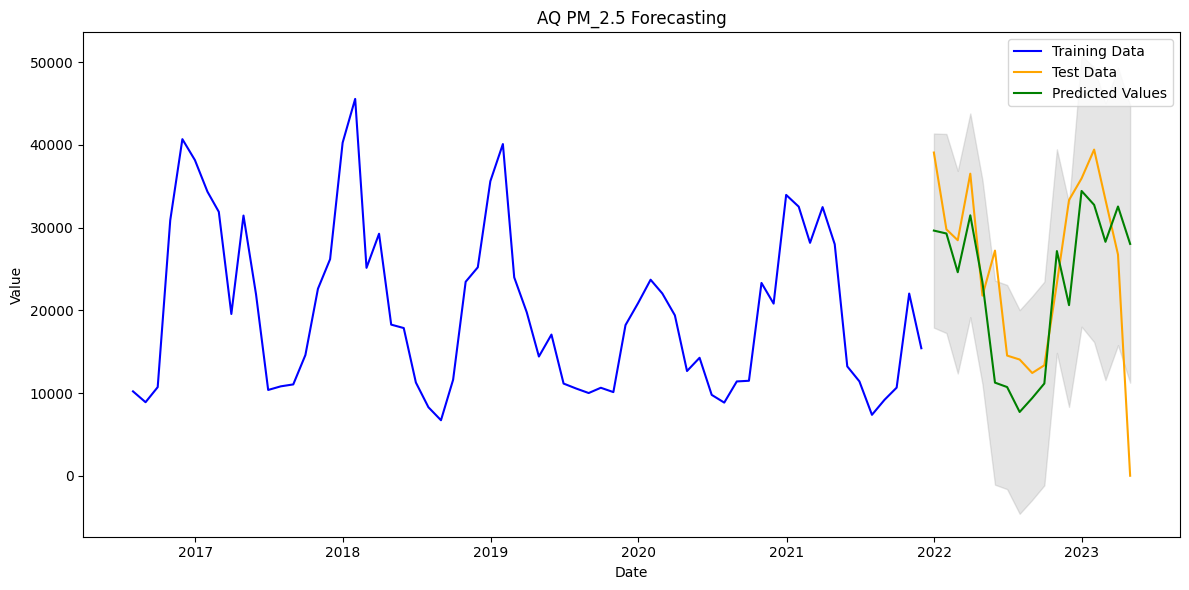

In [23]:
# Step 6: Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(train['Value'], label='Training Data', color='blue')
plt.plot(test['Value'], label='Test Data', color='orange')
plt.plot(predicted_mean, label='Predicted Values', color='green')
plt.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('AQ PM_2.5 Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('images/AQ_prediction.png')
plt.show()

## Complete Analysis for final submission DONE

# Other models explored for analysis

In [ ]:
plt.figure(figsize=(14,4))
#plt.plot(daily_totals)
plt.plot(monthly_totals)
plt.title('AQ PM2_5 Monthly Data', loc = 'center')
plt.grid();

In [ ]:
#aq_decomposition = sm.tsa.seasonal_decompose(monthly_totals['Value'], model='additive', period = 12)

# Plot the decomposed components
aq_decomposition.plot()
plt.show()

In [ ]:
plt.plot(aq_decomposition.resid)

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(aq_decomposition.resid.dropna(), lags=10)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [ ]:
y_hist = daily_totals.loc[:'2022-06']
y_future = daily_totals.loc['2022-06':]

In [ ]:
y_hist = monthly_totals.loc[:'2022-06']
y_future = monthly_totals.loc['2022-06':]

In [ ]:
plt.plot(y_hist, label = 'historical')
plt.plot(y_future, label = 'future')
plt.legend();

In [ ]:
stl = STL(y_hist['Value'], period = 12)
results = stl.fit()

In [ ]:
results.resid

In [ ]:
plt.plot(results.trend)
plt.plot(y_hist)
plt.title('Trend with Air Quality PM2.5 Data')

In [ ]:
season_and_trend = results.seasonal + results.trend

In [ ]:
plt.plot(season_and_trend['2020':], label = 'seasonal + trend')
plt.plot(y_hist['2020':], label = 'actual')
plt.grid()
plt.legend()
plt.xticks(rotation = 90);

Exploring the residuals

In [ ]:
results.

In [ ]:
plt.plot(results.resid)
plt.grid()

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(results.resid, lags=10)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
plot_acf(results.resid, ax = ax[0]);
ax[0].grid()
plot_pacf(results.resid, ax = ax[1])
ax[1].grid();

In [ ]:
results = adfuller(monthly_totals.values)
results

Check if $p-value < 0.05$ ? (i.e 5%)

In [ ]:
results[1] < 0.05

In [ ]:
y_historical, y_future = daily_totals.iloc[:int(len(daily_totals) * 0.9)], daily_totals.iloc[int(len(daily_totals) * 0.9):]

In [ ]:
y_historical = y_hist

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y_historical, ax = ax[0]);
ax[0].grid()
plot_pacf(y_historical, ax = ax[1], method = 'ywm');
ax[1].grid()

## ARMA

In [ ]:
p, q = 2, 1
arma = ARIMA(y_historical, order=(p, 0, q)).fit()

In [ ]:
hist_preds = arma.predict()

In [ ]:
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'model')
plt.plot(y_historical, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

In [ ]:
future_preds = arma.forecast(steps = len(y_future))

# Answer check
print(future_preds.tail())
print(y_future.tail())

In [ ]:
resids =monthly_totals - future_preds

In [ ]:
plt.figure(figsize = (12, 4))
plt.plot(y_future, label = 'data')
plt.plot(future_preds, label = 'predictions')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

# SARIMAX

In [ ]:
X_train, X_test = monthly_totals.iloc[:int(len(monthly_totals) * 0.9)], monthly_totals.iloc[int(len(monthly_totals) * 0.9):]

In [ ]:
X_train.tail()

In [ ]:
X_test.head()

In [ ]:
plt.plot(X_train, label = 'historical')
plt.plot(X_test, label = 'future')
plt.legend();

In [ ]:
result = adfuller(X_train)

In [ ]:
pval = result[1]

# Answer check
print(f'The p-value is {pval: .4f}')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(X_train, ax = ax[0]);
ax[0].grid()
plot_pacf(X_train, ax = ax[1], method = 'ywm');
ax[1].grid()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(
    X_train, 
    order=(1,0,2), 
    seasonal_order=(1,0,2,12),
).fit()

In [ ]:
sarima.summary()

In [ ]:
plt.plot(X_train.index, sarima.predict())
plt.plot(X_train.index, X_train, alpha = 0.5)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model')
plt.grid();

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

# Plot the SARIMA predictions with a solid line and a distinct color
plt.plot(X_train.index, sarima.predict(), color='blue', label='SARIMA Predictions', linewidth=2)

# Plot the actual training data with a dashed line and a lighter color
plt.plot(X_train.index, X_train, color='orange', label='Actual Data', linestyle='--', alpha=0.5)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=60)

# Set the title of the plot
plt.title('The SARIMA Model')

# Add a grid for better visualization
plt.grid()

# Add a legend to distinguish between the series
plt.legend()

# Save the figure as a PNG file
#plt.savefig('images/Try-It_10-2_sarima_model_plot.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Assuming sarima is already fitted to the training data (X_train)
# Forecast the next 12 months
forecast_periods = len(X_test)
forecast = sarima.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=X_test.index[0], periods=forecast_periods, freq='M')
forecast_values = forecast.predicted_mean

In [ ]:
forecast_df = pd.DataFrame({
    'date': pd.date_range(start='2022-07-29', periods=forecast_periods),
    'PC2_5': forecast_values
})

In [ ]:
forecast_df.set_index('date', inplace=True)

In [ ]:
# Create a DataFrame for the forecasted values
#forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['PC2_5'])

In [ ]:
forecast_df.head()

In [ ]:
# Plot the actual test data and the forecast
plt.figure(figsize=(18, 6))
plt.plot(X_test.index, X_test, color='orange', label='Actual Test Data', linestyle='--', alpha=0.5)
plt.plot(forecast_df.index, forecast_df['PC2_5'], color='blue', label='SARIMA Forecast', linewidth=2)

#plt.plot(forecast_df.index, forecast_values, color='blue', label='SARIMA Forecast', linewidth=2)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=60)

# Set the title of the plot
plt.title('SARIMA Forecast vs Actual Test Data')

# Add a grid for better visualization
plt.grid()

# Add a legend to distinguish between the series
plt.legend()

# Save the figure as a PNG file
#plt.savefig('sarima_forecast_plot.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
forecast_values

In [ ]:
X_test

In [ ]:
sarima.plot_diagnostics(figsize=(15, 12))

In [ ]:
print(forecast.summary_frame())  # Check the summary of the forecast   